In [1]:
import requests
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Simple example

In [2]:
#res = requests.get('https://api.github.com/users/defunkt')
#res.json()
#print(json.dumps(dict(res.headers), indent=1))

### Search without auth

In [3]:
params = {'q' : 'stars:50..*', 'page': '1', 'per_page':'100'}
api = 'https://api.github.com/search/repositories'
data = []
for i in range(10):
    r = requests.get(api, params=params)
    json_response = json.loads(r.text)
    data.append(json_response)
    if 'next' in r.links: 
        api = r.links['next']['url']        

In [9]:
print('total number of pages: ', len(data))

total number of pages:  10


In [10]:
print("total number of results: " +  str(r.json()['total_count']) )
print("total number of items: " +  str(len(r.json()['items'])))
#print(json.dumps(dict(r.headers), indent=1))
#print('---------------')
#print(datetime.datetime.fromtimestamp(int(r.headers['X-RateLimit-Reset'])).strftime('%c'))

total number of results: 392958
total number of items: 100


In [11]:
dg = pd.DataFrame()
for d in data:
    dfItem = pd.DataFrame.from_records(d)
    dg = dg.append(dfItem, ignore_index=True)

In [12]:
df = pd.DataFrame()
for d in data:
    dfItem = pd.DataFrame.from_records(d['items'])
    df = df.append(dfItem, ignore_index=True)

### Columns name dg has only three columes and we expands items to build another  dataset

In [13]:
dg.columns

Index(['incomplete_results', 'items', 'total_count'], dtype='object')

In [14]:
df.columns

Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_issues',
       'has_projects', 'has_downloads', 'has_wiki', 'has

In [15]:
df.shape

(1000, 74)

### feature enginering

source: https://github.com/krishnaik06/Complete-Feature-Selection

#### exclude constant collmns

In [17]:
#[any(df[col] != False) for col in ['has_downloads', 'disabled	open_issues_count	fork]
const_cols = []
for col in ['has_issues', 'archived', 'has_pages',  'has_projects', 'has_wiki', 'has_downloads','disabled', 'fork' ]:
    if len(df[col].unique()) == 1:
        const_cols.append(col)
const_cols

['archived', 'disabled', 'fork']

#### check categorical data for language

<AxesSubplot:>

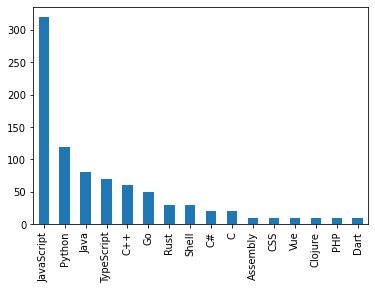

In [19]:
df['language'].value_counts().plot(kind='bar')

#### excludes some columns manually <br> excludes constant columns obtained in previous section <br> remove language column for convenience

In [20]:
cols = []
list_ = ['url', '_at', 'description', 'id', 'owner', 'score', 'default_branch', 'homepage', 'license', 'name', 'watchers_count']  + const_cols + ['language']
for w in set(df.columns):
    if not any(word in w for word in list_):
        cols.append(w)
        
df2 = df[cols]
#df2.head()

### convert true and false into numbers

In [21]:
df2 = df2*1
df2.head()

,open_issues_count,has_wiki,has_downloads,has_projects,watchers,stargazers_count,size,has_pages,has_issues,open_issues,private
0,248,0,1,0,324428,324428,197549,1,1,248,0
1,16810,0,1,0,257104,257104,183401,0,0,16810,0
2,31,1,1,0,188740,188740,10804,1,1,31,0
3,536,1,1,1,183726,183726,27322,0,1,536,0
4,45,0,1,0,170509,170509,13138,0,1,45,0


#### Find correlated collumns

<AxesSubplot:>

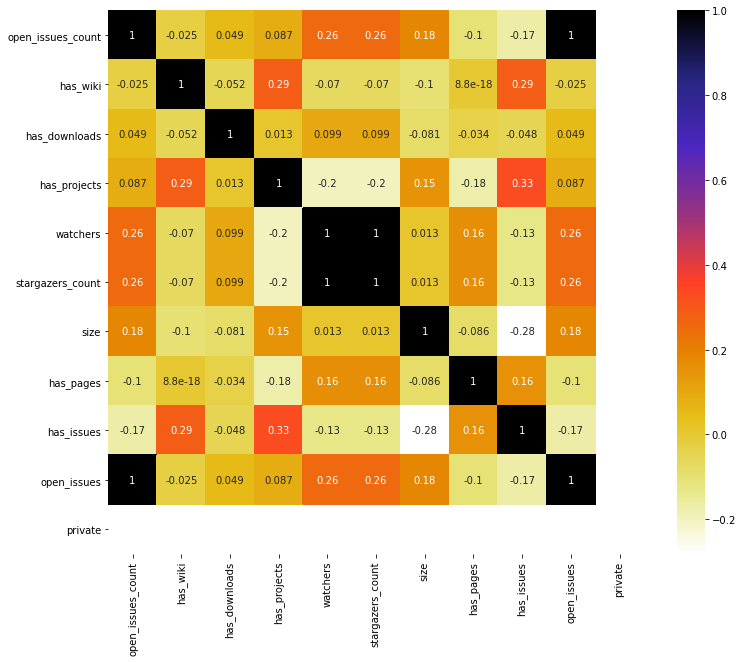

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(df2.corr(), annot=True, cmap=plt.cm.CMRmap_r)

### based on the correlation delete  open_issues

In [23]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [25]:
corr_features = correlation(df2, 0.8)
corr_features

{'open_issues', 'stargazers_count'}

In [26]:
df2 = df2.drop(['open_issues','watchers'],axis=1)
df2.head()

,open_issues_count,has_wiki,has_downloads,has_projects,stargazers_count,size,has_pages,has_issues,private
0,248,0,1,0,324428,197549,1,1,0
1,16810,0,1,0,257104,183401,0,0,0
2,31,1,1,0,188740,10804,1,1,0
3,536,1,1,1,183726,27322,0,1,0
4,45,0,1,0,170509,13138,0,1,0


#### drop the nan values

In [27]:
df2 = df2.dropna()
df2.head()

,open_issues_count,has_wiki,has_downloads,has_projects,stargazers_count,size,has_pages,has_issues,private
0,248,0,1,0,324428,197549,1,1,0
1,16810,0,1,0,257104,183401,0,0,0
2,31,1,1,0,188740,10804,1,1,0
3,536,1,1,1,183726,27322,0,1,0
4,45,0,1,0,170509,13138,0,1,0


#### check for feature importance based on mutual information

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df2.drop(labels=['stargazers_count'], axis=1),df2['stargazers_count'],test_size=0.3, random_state=0)

<AxesSubplot:>

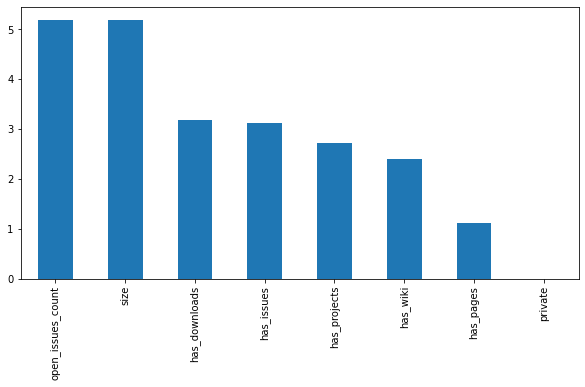

In [29]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = pd.Series(mutual_info_classif(X_train, y_train))
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 5))

### we can drop 'private' from the data

In [21]:
df2_temp = df2.drop('private', axis = 1)
X_train,X_test,y_train,y_test=train_test_split(df2.drop(labels=['stargazers_count'], axis=1),df2_temp['stargazers_count'],test_size=0.3, random_state=0)

### save data

In [53]:
df2_temp.to_pickle('model_data')

### data normalization

In [22]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#cols = ['open_issues_count', 'size']
#X_train[cols] = sc.fit_transform(X_train[cols])
#X_test[cols] = sc.transform(X_test[cols])

### should we scale the target as well ?

### train the model using pytorch

#### repeat based on chi2 test
chi2 returns 2 values
Fscore and the pvalue

In [24]:
from sklearn.feature_selection import chi2
f_p_values=chi2(X_train,y_train)
print(f_p_values)

ValueError: Input X must be non-negative.

In [ ]:
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
p_values

In [ ]:
plt.subplots(figsize=(15, 3))
plt.subplot(1,2,1)
plt.plot(df['watchers'])
plt.axhline(y=50, color='r', linestyle='-')
plt.subplot(1,2,2)
plt.hist(df['watchers'])

In [ ]:
def plot_q(quantity):
    plt.subplots(figsize=(15, 3))
    plt.subplot(1,2,1)
    plt.plot(df[quantity])
    #plt.axhline(y=50, color='r', linestyle='-')
    plt.subplot(1,2,2)
    plt.hist(df[quantity])

In [ ]:
plot_q('forks')

In [ ]:
df.groupby('language')['forks'].mean().plot(kind='bar')

### Not used code

### find keys in the itmes field

In [8]:
r_json.keys()

dict_keys(['total_count', 'incomplete_results', 'items'])

In [7]:
r_json = data[0]
items = r_json['items']
len(items)

100

In [6]:
[key for key in r_json]   

['total_count', 'incomplete_results', 'items']

In [7]:
print([(key) for key in r_json['items'][0]], '\t')

['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'license', 'fo

In [8]:
print(json.dumps(dict(r_json['items'][1]), indent=1))

{
 "id": 177736533,
 "node_id": "MDEwOlJlcG9zaXRvcnkxNzc3MzY1MzM=",
 "name": "996.ICU",
 "full_name": "996icu/996.ICU",
 "private": false,
 "owner": {
  "login": "996icu",
  "id": 48942249,
  "node_id": "MDQ6VXNlcjQ4OTQyMjQ5",
  "avatar_url": "https://avatars.githubusercontent.com/u/48942249?v=4",
  "gravatar_id": "",
  "url": "https://api.github.com/users/996icu",
  "html_url": "https://github.com/996icu",
  "followers_url": "https://api.github.com/users/996icu/followers",
  "following_url": "https://api.github.com/users/996icu/following{/other_user}",
  "gists_url": "https://api.github.com/users/996icu/gists{/gist_id}",
  "starred_url": "https://api.github.com/users/996icu/starred{/owner}{/repo}",
  "subscriptions_url": "https://api.github.com/users/996icu/subscriptions",
  "organizations_url": "https://api.github.com/users/996icu/orgs",
  "repos_url": "https://api.github.com/users/996icu/repos",
  "events_url": "https://api.github.com/users/996icu/events{/privacy}",
  "received_even

### double check the stars

In [ ]:
#print(json.dumps(dict(r_json['items'][0]), indent=1))

In [ ]:
items = r_json['items']
ll = len(items)
print('total itmes: ', ll)
print([items[i]['watchers'] for i in range(ll)], '\t')